In [4]:
from pathlib import Path
import sys, sqlite3, yaml, pandas as pd

# Текущая рабочая директория Jupyter
cwd = Path.cwd()

# Если CWD = Project/notebooks, то корень проекта = parent
project_root = str(cwd.parent)

# Добавляем корень проекта в sys.path (в начало, чтобы он имел приоритет)
if project_root not in sys.path:
    sys.path.insert(0, project_root)

pd.set_option("display.width", 2000)     # максимальная ширина в символах
pd.set_option("display.max_colwidth", None)

from config import DB_SNAPSHOT_PATH, DEFAULT_CONFIG_PATH, MODELS_DIR

In [2]:
with open(DEFAULT_CONFIG_PATH, "r", encoding="utf-8") as f:
    cfg = yaml.safe_load(f)

sql = cfg["data"]["sql"]
with sqlite3.connect(DB_SNAPSHOT_PATH) as conn:
    df = pd.read_sql(sql, conn)

df.head()

,label,error_text_tokens,ctx_tokens,ctx_numeric
0,1,"[""C2065"", ""0"", ""необъявленный"", ""идентификатор""]","[""F_TOK=INT"", ""F_TOK=<ID_VAR_SCALAR_DECL>"", ""F_TOK=OP_="", ""F_TOK=<NUM>"", ""F_TOK=OP_*"", ""F_TOK=<ID_VAR_SCALAR_USE>"", ""F_TOK=OP_,"", ""F_TOK=<ID_VAR_SCALAR_DECL>"", ""F_TOK=OP_="", ""F_TOK=<NUM>"", ""F_TOK=OP_*"", ""F_TOK=<ID_VAR_SCALAR_USE>"", ""F_TOK=;"", ""F_TOK=INT"", ""F_TOK=<ID_VAR_SCALAR_DECL>"", ""F_TOK=OP_="", ""F_TOK=<NUM>"", ""F_TOK=OP_,"", ""F_TOK=<ID_VAR_SCALAR_DECL>"", ""F_TOK=OP_="", ""F_TOK=<NUM>"", ""F_TOK=;"", ""F_TOK=INT"", ""F_TOK=<ID_VAR_SCALAR_DECL>"", ""F_TOK=OP_="", ""F_TOK=<NUM>"", ""F_TOK=OP_,"", ""F_TOK=<ID_VAR_SCALAR_DECL>"", ""F_TOK=OP_="", ""F_TOK=０"", ""F_TOK=;"", ""F_TOK=FOR"", ""F_TOK=("", ""F_TOK=INT"", ""F_TOK=<ID_VAR_SCALAR_DECL>"", ""F_TOK=OP_="", ""F_TOK=<NUM>"", ""F_TOK=;"", ""F_TOK=<ID_VAR_SCALAR_USE>"", ""F_TOK=OP_*"", ""F_TOK=<ID_VAR_SCALAR_USE>"", ""F_TOK=OP_<="", ""F_TOK=<ID_VAR_SCALAR_USE>"", ""F_TOK=;"", ""F_TOK=<ID_VAR_SCALAR_USE>"", ""F_TOK=OP_++"", ""F_TOK=)"", ""F_TOK={"", ""F_CORE__KIND=VAR_DECL"", ""F_CORE__TYPE_CAT=T_INT"", ""F_PARENT__D0=DECL_STMT"", ""F_PARENT__D1=COMPOUND_STMT"", ""F_PARENT__D2=FUNCTION_DECL"", ""F_PARENT__KIND=DECL_STMT"", ""F_PARENT__KIND=COMPOUND_STMT"", ""F_PARENT__KIND=FUNCTION_DECL"", ""F_INC__CAT=IO"", ""F_USING_NS__NS=std"", ""F_DECL__VARS_TYPE_CAT=T_INT""]","{""N_TOK__LOCAL_TOK_LEN"": 48.0, ""N_CORE__HAS_CORE_INFO"": 1.0, ""N_CORE__IS_DECL"": 1.0, ""N_CORE__IS_EXPR"": 0.0, ""N_CORE__IS_STMT"": 0.0, ""N_CORE__HAS_RESULT_TYPE"": 0.0, ""N_META__HAS_CURSOR_META"": 0.0, ""N_PARENT__CHAIN_LEN"": 3.0, ""N_INC__INCLUDES"": 1.0, ""N_MACRO__HAS_MACROS"": 0.0, ""N_USING__DIRECTIVES"": 1.0, ""N_USING__DECLS"": 0.0, ""N_TYPEDEF__TYPEDEFS"": 0.0, ""N_NS__NAMESPACES"": 0.0, ""N_DECL__VAR_KIND__VAR_DECL"": 24.0, ""N_DECL__FUNC_KIND__FUNCTION_DECL"": 1.0, ""N_DECL__TYPES_TOTAL"": 0.0, ""N_DECL__VARS_TOTAL"": 24.0, ""N_DECL__FUNCS_TOTAL"": 1.0, ""N_DECL__VARS_TYPE__T_INT"": 24.0}"
1,1,"[""C2065"", ""0"", ""необъявленный"", ""идентификатор""]","[""F_TOK=<ID_VAR_SCALAR_USE>"", ""F_TOK=OP_<<"", ""F_TOK=<ID_VAR_SCALAR_USE>"", ""F_TOK=["", ""F_TOK=<ID_VAR_SCALAR_USE>"", ""F_TOK=]"", ""F_TOK=OP_<<"", ""F_TOK=<ID_FUNC_USE_LIB>"", ""F_TOK=;"", ""F_TOK=}"", ""F_TOK=RETURN"", ""F_TOK=０"", ""F_TOK=;"", ""F_TOK=}"", ""F_CORE__KIND=RETURN_STMT"", ""F_CORE__TYPE_CAT=T_UNKNOWN"", ""F_PARENT__D0=COMPOUND_STMT"", ""F_PARENT__D1=FUNCTION_DECL"", ""F_PARENT__KIND=COMPOUND_STMT"", ""F_PARENT__KIND=FUNCTION_DECL"", ""F_INC__CAT=IO"", ""F_USING_NS__NS=std"", ""F_DECL__VARS_TYPE_CAT=T_INT"", ""F_DECL__VARS_TYPE_CAT=T_ARRAY""]","{""N_TOK__LOCAL_TOK_LEN"": 14.0, ""N_CORE__HAS_CORE_INFO"": 1.0, ""N_CORE__IS_DECL"": 0.0, ""N_CORE__IS_EXPR"": 0.0, ""N_CORE__IS_STMT"": 1.0, ""N_CORE__HAS_RESULT_TYPE"": 0.0, ""N_META__HAS_CURSOR_META"": 0.0, ""N_PARENT__CHAIN_LEN"": 2.0, ""N_INC__INCLUDES"": 1.0, ""N_MACRO__HAS_MACROS"": 0.0, ""N_USING__DIRECTIVES"": 1.0, ""N_USING__DECLS"": 0.0, ""N_TYPEDEF__TYPEDEFS"": 0.0, ""N_NS__NAMESPACES"": 0.0, ""N_DECL__VAR_KIND__VAR_DECL"": 7.0, ""N_DECL__FUNC_KIND__FUNCTION_DECL"": 1.0, ""N_DECL__TYPES_TOTAL"": 0.0, ""N_DECL__VARS_TOTAL"": 7.0, ""N_DECL__FUNCS_TOTAL"": 1.0, ""N_DECL__VARS_TYPE__T_INT"": 6.0, ""N_DECL__VARS_TYPE__T_ARRAY"": 1.0}"
2,1,"[""C2065"", ""0"", ""необъявленный"", ""идентификатор""]","[""F_TOK=}"", ""F_USING_NS__NS=std"", ""F_DECL__VARS_TYPE_CAT=T_INT""]","{""N_TOK__LOCAL_TOK_LEN"": 1.0, ""N_CORE__HAS_CORE_INFO"": 0.0, ""N_META__HAS_CURSOR_META"": 0.0, ""N_PARENT__CHAIN_LEN"": 0.0, ""N_INC__INCLUDES"": 0.0, ""N_MACRO__HAS_MACROS"": 0.0, ""N_USING__DIRECTIVES"": 1.0, ""N_USING__DECLS"": 0.0, ""N_TYPEDEF__TYPEDEFS"": 0.0, ""N_NS__NAMESPACES"": 0.0, ""N_DECL__VAR_KIND__VAR_DECL"": 2.0, ""N_DECL__FUNC_KIND__FUNCTION_DECL"": 1.0, ""N_DECL__TYPES_TOTAL"": 0.0, ""N_DECL__VARS_TOTAL"": 2.0, ""N_DECL__FUNCS_TOTAL"": 1.0, ""N_DECL__VARS_TYPE__T_INT"": 2.0}"
3,1,"[""C2065"", ""0"", ""необъявленный"", ""идентификатор""]","[""F_TOK=}"

In [ ]:
from ml_helpers.vectorizers import build_vectorizer_from_cfg
from sklearn.model_selection import train_test_split
from ml_helpers.tuning import make_cv


y = df["label"].astype(int).to_numpy()

feat = build_vectorizer_from_cfg(cfg)
df_X = df.drop(columns=["label"])

X_dev, X_test, y_dev, y_test = train_test_split(
    df_X, y,
    test_size=0.15,
    random_state=42,
    stratify=y
)

# выбираем стратегию CV по имени
cv_name = cfg["training"]["cv_strategy"]
strat_cfg = next(s for s in cfg["cross_val_score"]["strategies"] if s["name"] == cv_name)
cv = make_cv(strat_cfg)

In [ ]:
# from joblib import Memory
from sklearn.experimental import enable_halving_search_cv  # noqa: F401
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, HalvingGridSearchCV, HalvingRandomSearchCV # type: ignore
from sklearn.pipeline import Pipeline
from ml_helpers.tuning import _import_obj
from ml_helpers.tuning import prepare_param_grids, _infer_max_resources_from_grid


active = cfg["active_model"]
m_cfg = cfg["models"][active]

Estimator = _import_obj(m_cfg["type"])
est = Estimator(**(m_cfg.get("params", {}) or {}))

# cache_dir = "/tmp/sk_cache"
# memory = Memory(cache_dir, verbose=0)

# pipe = Pipeline([("feat", feat), ("clf", est)], memory=memory)

pipe = Pipeline([("feat", feat), ("clf", est)])

n_jobs = cfg["training"]["tuning"]["n_jobs"]
method = cfg["training"]["tuning"]["method"]
verbose = cfg["training"]["tuning"].get("verbose", 0)
error_score = cfg["training"]["tuning"].get("error_score", "raise")

h_cfg = m_cfg.get(method, {}) or {}
return_train_score = h_cfg.get("return_train_score", False)
random_state = h_cfg.get("random_state", None)

param_grid = prepare_param_grids(m_cfg)

scoring_cfg = cfg["training"]["tuning"]["scoring"]
refit_cfg = cfg["training"]["tuning"]["refit"]

is_halving = method in {"halving_grid", "halving_random"}

if is_halving:
    if isinstance(refit_cfg, str):
        scoring = refit_cfg
        refit = True
    else:
        scoring = scoring_cfg
        refit = refit_cfg
        if isinstance(scoring, (list, tuple, dict)):
            raise ValueError("Halving* не поддерживает несколько метрик")
else:
    scoring = scoring_cfg
    refit = refit_cfg

def _infer_max_resources_from_grid(param_grid, resource_name : str):
    vals = []
    grids = param_grid if isinstance(param_grid, list) else [param_grid]
    for g in grids:
        if resource_name in g:
            v = g[resource_name]
            if isinstance(v, (list, tuple)):
                vals.extend([x for x in v if x is not None])
    return max(vals) if vals else None


if method == "none" or not param_grid:
    pipe.fit(df_X, y)
    best_estimator = pipe
    best_params = {}
else:
    if method == "grid":
        search = GridSearchCV(
            estimator=pipe,
            param_grid=param_grid,
            scoring=scoring,
            refit=refit,
            cv=cv,
            n_jobs=n_jobs,
            verbose=verbose,
            error_score=error_score,
            return_train_score=return_train_score,
        )
    elif method == "random":
        search = RandomizedSearchCV(
            estimator=pipe,
            param_distributions=param_grid,
            scoring=scoring,
            refit=refit,
            cv=cv,
            n_jobs=n_jobs,
            verbose=verbose,
            error_score=error_score,
            return_train_score=return_train_score,
            random_state=random_state,
        )
    elif method in {"halving_grid", "halving_random"}:

        factor = h_cfg.get("factor", 3)
        resource = h_cfg.get("resource", "n_samples")
        min_resources = h_cfg.get("min_resources", "exhaust" if method == "halving_grid" else "smallest")
        max_resources = h_cfg.get("max_resources", "auto")
        aggressive_elimination = h_cfg.get("aggressive_elimination", False)

        # Если ресурс НЕ n_samples, max_resources обязан быть int (не "auto")
        if resource != "n_samples" and max_resources == "auto":
            inferred = _infer_max_resources_from_grid(param_grid, resource)
            if inferred is None:
                raise ValueError(
                    f"resource={resource!r} => max_resources must be set explicitly "
                    f"(or include {resource!r} in the grid so it can be inferred)."
                )
            max_resources = int(inferred)

        if method == "halving_grid":
            search = HalvingGridSearchCV(
                estimator=pipe,
                param_grid=param_grid,
                factor=factor,
                resource=resource,
                min_resources=min_resources,
                max_resources=max_resources,
                aggressive_elimination=aggressive_elimination,
                cv=cv_split,
                scoring=scoring,
                refit=refit,
                n_jobs=n_jobs,
                verbose=verbose,
                error_score=error_score,
                return_train_score=return_train_score,
                random_state=random_state,
            )
        else:
            n_candidates = h_cfg.get("n_candidates", "exhaust")

            if n_candidates == "exhaust" and min_resources == "exhaust":
                raise ValueError("HalvingRandomSearchCV: n_candidates='exhaust' несовместим с min_resources='exhaust'")

            search = HalvingRandomSearchCV(
                estimator=pipe,
                param_distributions=param_grid,
                n_candidates=n_candidates,
                factor=factor,
                resource=resource,
                min_resources=min_resources,
                max_resources=max_resources,
                aggressive_elimination=aggressive_elimination,
                cv=cv,
                scoring=scoring,
                refit=refit,
                n_jobs=n_jobs,
                verbose=verbose,
                error_score=error_score,
                return_train_score=return_train_score,
                random_state=random_state,
            )
    else:
        raise ValueError(f"Unknown method: {method}")

    search.fit(X_dev, y_dev)
    best_estimator = search.best_estimator_
    best_params = search.best_params_
    best_score = search.best_score_

    print("best_estimator:", best_estimator)
    print("best_params:", best_params)
    print("best_score:", best_score)

n_iterations: 2
n_required_iterations: 5
n_possible_iterations: 2
min_resources_: 32
max_resources_: 256
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 144
n_resources: 32
Fitting 5 folds for each of 144 candidates, totalling 720 fits


In [5]:
from mlapp import load_sklearn_model_bundle


model_bundle = load_sklearn_model_bundle(
            MODELS_DIR / "sgd_log_regression_1",
            strict_versions=False,
            expected_steps=("feat", "clf"),
        )

best_estimator = model_bundle.pipe

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.base import clone


best_unfitted = clone(best_estimator)
n_jobs = cfg["training"]["tuning"]["n_jobs"]

y_dev_oof = cross_val_predict(best_unfitted, X_dev, y_dev, cv=cv_split, n_jobs=n_jobs)
print("DEV (OOF / CV-valid):")
print(classification_report(y_dev, y_dev_oof))

y_test_pred = best_estimator.predict(X_test)
print("TEST:")
print(classification_report(y_test, y_test_pred))

DEV (OOF / CV-valid):
              precision    recall  f1-score   support

           1       0.92      0.98      0.95     40213
           2       0.57      0.26      0.36      4529
           3       0.99      0.98      0.99     10169
           4       0.83      0.98      0.90      5148
           5       0.92      0.67      0.78      2721
           6       1.00      0.98      0.99      6100
           7       1.00      1.00      1.00     20583
           8       0.98      0.98      0.98      8004
           9       0.52      0.70      0.60       400
          10       1.00      1.00      1.00     15453
          11       1.00      1.00      1.00      8687
          12       1.00      1.00      1.00     11782
          13       1.00      1.00      1.00     15432
          14       0.99      0.99      0.99      2652
          15       1.00      1.00      1.00      2189
          16       0.98      0.93      0.95      1256
          17       0.94      0.99      0.97      1508
     

In [8]:
import matplotlib.pyplot as plt, numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, matthews_corrcoef, make_scorer, roc_curve, auc, accuracy_score, roc_auc_score
from numpy import interp
from sklearn.preprocessing import label_binarize

                                            # "true" | "pred" | "all" | None
def plot_confusion(y_true, y_pred, *, labels=None, normalize="true", title="Confusion matrix"):
    # labels лучше фиксировать, чтобы порядок классов был стабильным
    if labels is None:
        labels = np.unique(np.concatenate([np.asarray(y_true), np.asarray(y_pred)]))

    n_classes = len(labels)

    # Для 19 классов числа в клетках обычно мешают
    # include_values = (n_classes <= 12)
    include_values = True

    # Фигура пропорционально числу классов
    side = max(8, min(20, 0.6 * n_classes))
    fig, ax = plt.subplots(figsize=(side, side))

    disp = ConfusionMatrixDisplay.from_predictions(
        y_true, y_pred,
        labels=labels,
        normalize=normalize,
        include_values=include_values,
        values_format=".2f" if normalize else "d",
        xticks_rotation=90,
        ax=ax
    )
    ax.set_title(title)
    plt.tight_layout()
    plt.show()


def multiclass_scores(est, X):
    if hasattr(est, "decision_function"):
        S = est.decision_function(X)
        # (n_samples, n_classes) для multiclass
        return S
    if hasattr(est, "predict_proba"):
        P = est.predict_proba(X)
        return P
    raise TypeError("Estimator has neither decision_function nor predict_proba")


def plot_multiclass_roc_cv(estimator, X, y, cv=None, plot="micro"):
    if cv is None:
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    classes = np.unique(y)
    y_bin_all = label_binarize(y, classes=classes)

    # накапливаем OOF-скоры
    scores_oof = np.empty((len(y), len(classes)), dtype=np.float64)
    scores_oof.fill(np.nan)

    for fold, (tr, te) in enumerate(cv.split(X, y), 1):
        est = clone(estimator)
        est.fit(X[tr], y[tr])

        S = multiclass_scores(est, X[te])

        # привести к (n_te, n_classes) если это вероятности/скоры
        S = np.asarray(S)
        if S.ndim == 1:
            # бинарный случай; но у вас 19 классов, обычно сюда не попадёте
            S = np.column_stack([-S, S])

        if not np.isfinite(S).all():
            bad = np.where(~np.isfinite(S))
            raise ValueError(
                f"Non-finite scores on fold {fold}: "
                f"{len(bad[0])} bad values. "
                f"Fix training stability (regularization/scaling)."
            )

        # Важно: классы в estimator.classes_ могут быть подмножеством,
        # поэтому нужно сопоставить столбцы по меткам.
        # Для LogReg/SGD обычно classes_ == classes при стратификации,
        # но лучше сделать корректно:
        col_map = {c:i for i,c in enumerate(est.classes_)}
        S_full = np.zeros((len(te), len(classes)), dtype=np.float64)
        for j, c in enumerate(classes):
            if c in col_map:
                S_full[:, j] = S[:, col_map[c]]
            else:
                # класс отсутствовал в обучении фолда -> оставляем 0
                S_full[:, j] = 0.0

        scores_oof[te] = S_full

    # micro ROC
    y_bin = y_bin_all
    y_score = scores_oof

    if not np.isfinite(y_score).all():
        raise ValueError("OOF scores contain NaN/Inf. Fix estimator stability first.")

    fpr, tpr, _ = roc_curve(y_bin.ravel(), y_score.ravel())
    roc_auc = auc(fpr, tpr)

    return fpr, tpr, roc_auc


def roc_auc_only(estimator, X, y_true, *, multi_class="ovr", average="weighted"):
    """
    Возвращает одно число ROC-AUC для binary/multiclass классификации.

    Для binary:
      - если есть predict_proba -> берём proba[:, 1]
      - иначе если есть decision_function -> берём decision_function
    Для multiclass:
      - используем predict_proba -> (n_samples, n_classes)
      - multi_class обязателен: 'ovr' или 'ovo'
      - average обычно: 'weighted' (как у вас roc_auc_ovr_weighted)

    Падает с понятной ошибкой, если scores содержат NaN/Inf или proba некорректные.
    """
    y_true = np.asarray(y_true)
    classes = np.unique(y_true)
    is_multiclass = (classes.size > 2)

    # 1) Получаем scores
    if hasattr(estimator, "predict_proba"):
        y_score = estimator.predict_proba(X)
        y_score = np.asarray(y_score)

        if not is_multiclass:
            # binary: берем вероятность класса classes_[1] (у sklearn это estimator.classes_[1])
            if y_score.ndim != 2 or y_score.shape[1] < 2:
                raise ValueError(f"predict_proba вернул shape={y_score.shape}, ожидалось (n_samples, 2+) для binary.")
            y_score_use = y_score[:, 1]
        else:
            # multiclass: нужен (n_samples, n_classes) и суммы по строкам ~ 1
            if y_score.ndim != 2:
                raise ValueError(f"predict_proba вернул shape={y_score.shape}, ожидалось 2D (n_samples, n_classes).")
            row_sums = y_score.sum(axis=1)
            if not np.all(np.isfinite(row_sums)):
                raise ValueError("predict_proba содержит NaN/Inf (суммы по строкам не finite).")
            # допускаем небольшую погрешность
            if not np.allclose(row_sums, 1.0, rtol=1e-3, atol=1e-6):
                raise ValueError(
                    "Для multiclass roc_auc_score ожидает вероятности, суммирующиеся в 1 по строкам. "
                    f"Сейчас min/max суммы: {row_sums.min():.6f}/{row_sums.max():.6f}."
                )
            y_score_use = y_score
    elif hasattr(estimator, "decision_function"):
        y_score = estimator.decision_function(X)
        y_score_use = np.asarray(y_score)
        if is_multiclass:
            # decision_function для multiclass roc_auc_score обычно не используют; ожидаются вероятности
            raise ValueError(
                "Для multiclass roc_auc_score ожидает вероятности predict_proba(X) (n_samples, n_classes). "
                "Ваш estimator не имеет predict_proba."
            )
    else:
        raise ValueError("Estimator должен иметь predict_proba или decision_function для вычисления ROC-AUC.")

    # 2) Проверка на NaN/Inf (ваша ошибка как раз про это)
    if not np.all(np.isfinite(y_score_use)):
        raise ValueError("Input contains NaN/Inf в y_score (scores для ROC-AUC).")

    # 3) Считаем ROC-AUC
    if not is_multiclass:
        return float(roc_auc_score(y_true, y_score_use))
    else:
        if multi_class not in {"ovr", "ovo"}:
            raise ValueError("multi_class должен быть 'ovr' или 'ovo' для multiclass")
        return float(roc_auc_score(y_true, y_score_use, multi_class=multi_class, average=average))

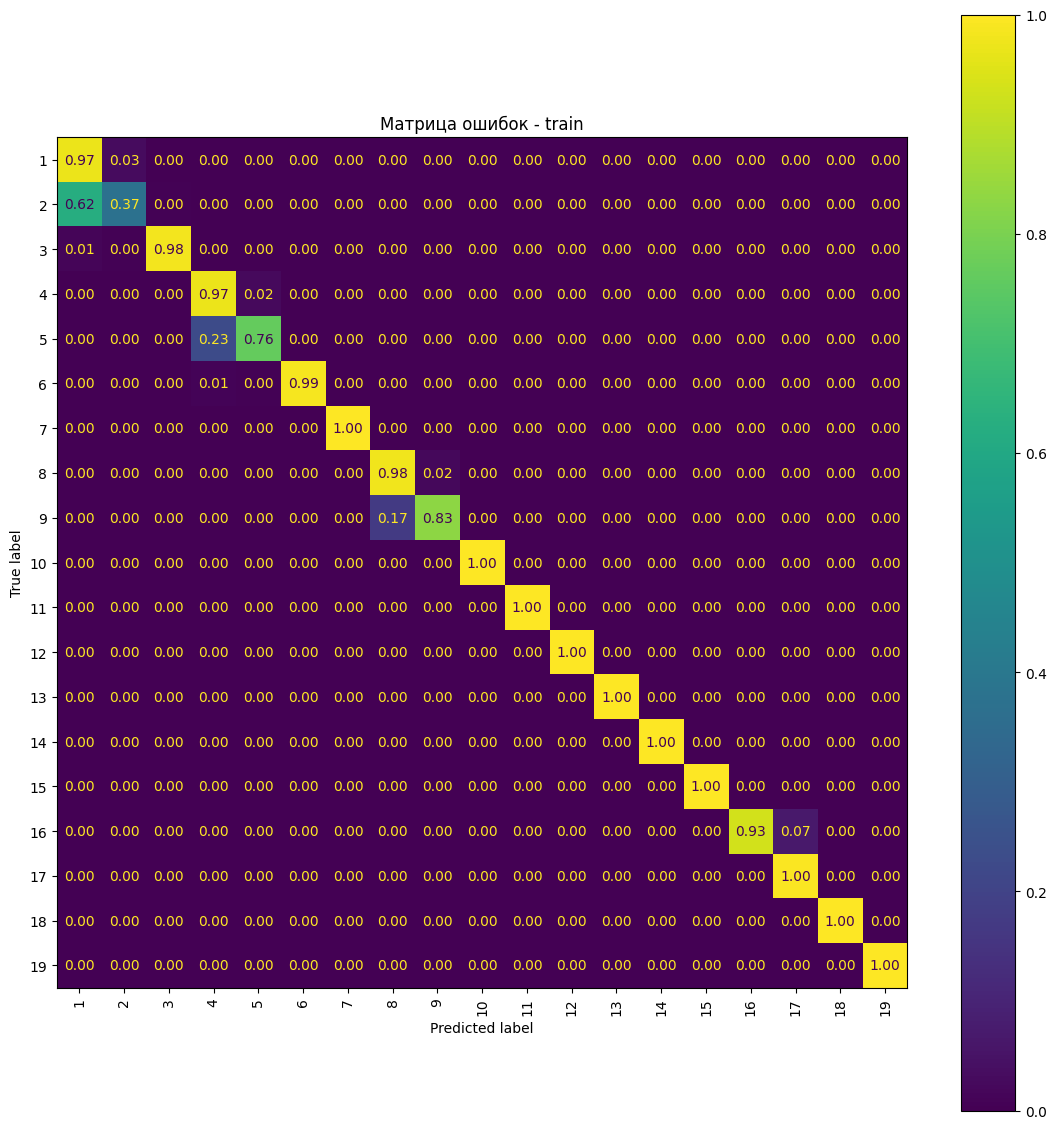

In [9]:
y_dev_pred = best_estimator.predict(X_dev)
plot_confusion(y_dev, y_dev_pred, title="Матрица ошибок - train")

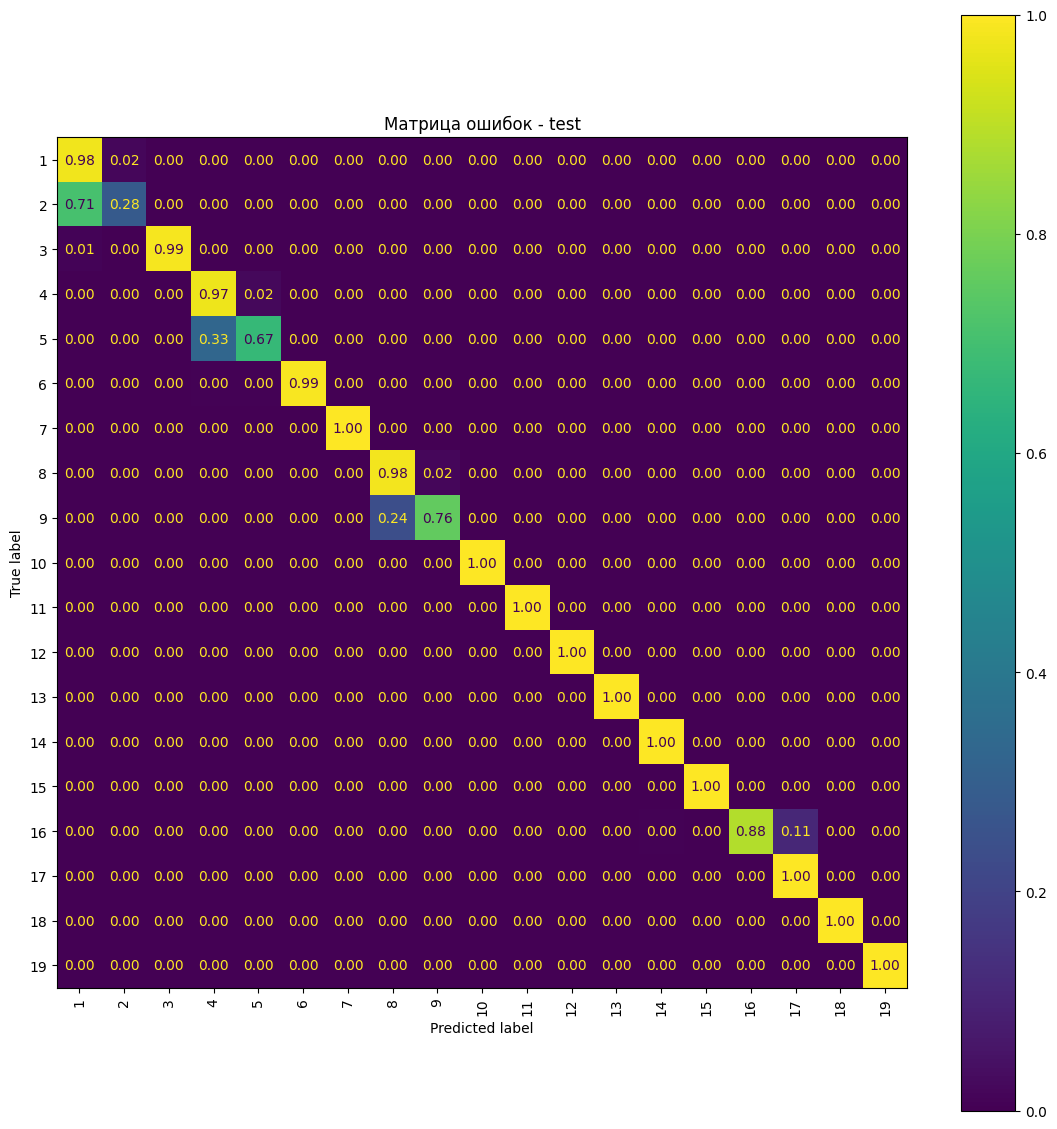

In [10]:
plot_confusion(y_test, y_test_pred, title="Матрица ошибок - test")

In [ ]:
auc_ovr_w = roc_auc_only(best_estimator, X_test, y_test, multi_class="ovr", average="weighted")
print(auc_ovr_w)

0.9935910482225305


In [12]:
auc_ovo_w = roc_auc_only(best_estimator, X_test, y_test, multi_class="ovo", average="weighted")
print(auc_ovo_w)

0.9921467502310214


In [ ]:
from dataclasses import dataclass
from typing import Literal

import numpy as np
import matplotlib.pyplot as plt

from sklearn.base import clone
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize


def _slice_X(X, idx):
    # X у вас pandas.DataFrame; но поддержим и numpy/sparse
    if hasattr(X, "iloc"):
        return X.iloc[idx]
    return X[idx]


def _get_final_estimator(est):
    # Pipeline -> последний clf, иначе сам est
    if hasattr(est, "named_steps") and "clf" in est.named_steps:
        return est.named_steps["clf"]
    return est


def _get_scores(est, X):
    """
    Вернёт:
      - multiclass: shape (n_samples, n_classes)
    """

    if hasattr(est, "predict_proba"):
        proba = est.predict_proba(X)
        return proba
    if hasattr(est, "decision_function"):
        dec = est.decision_function(X)
        return dec
    raise TypeError(
        "Estimator doesn't support predict_proba or decision_function; "
        "ROC needs continuous scores."
    )


@dataclass
class FoldRoc:
    fold: int
    auc_value: float
    fpr: np.ndarray
    tpr: np.ndarray


def plot_roc_per_fold_and_test(
    best_estimator,
    X_dev, y_dev,
    X_test, y_test,
    cv,
    *,
    multi_class : Literal["ovr", "ovo"],
    average_auc : Literal["micro", "macro", "weighted"],
    plot_chance_line : bool = True,
    title : str | None = None,
):
    """
    Строит ROC-кривые:
      - по каждому fold на X_dev (валидационная часть)
      - одну кривую на X_test (после fit на всём X_dev)
    Возвращает (fig, ax, fold_rocs, test_auc).
    """

    y_dev = np.asarray(y_dev)
    y_test = np.asarray(y_test)

    classes_all = np.unique(y_dev)
    n_classes = len(classes_all)

    fig, ax = plt.subplots(figsize=(8, 6))

    fold_rocs: list[FoldRoc] = []

    # --- CV ROC (по каждому fold) ---
    for fold_idx, (tr_idx, va_idx) in enumerate(cv.split(X_dev, y_dev), start=1):
        est = clone(best_estimator)
        X_tr = _slice_X(X_dev, tr_idx)
        y_tr = y_dev[tr_idx]
        X_va = _slice_X(X_dev, va_idx)
        y_va = y_dev[va_idx]

        est.fit(X_tr, y_tr)

        scores = _get_scores(est, X_va)

        # multiclass: micro-average ROC curve
        # Привязываем порядок классов к classes_ конкретно обученного clf
        clf = _get_final_estimator(est)
        classes_est = getattr(clf, "classes_", classes_all)

        # scores ожидаем (n, n_classes)
        if scores.ndim != 2 or scores.shape[1] != len(classes_est):
            raise ValueError(
                f"Expected scores shape (n_samples, n_classes={len(classes_est)}), got {scores.shape}"
            )

        y_va_bin = label_binarize(y_va, classes=classes_est)
        # micro-average ROC: считаем ROC по всем классам сразу (flatten)
        fpr, tpr, _ = roc_curve(y_va_bin.ravel(), scores.ravel())

        # AUC как метрика: через roc_auc_score с multi_class. :contentReference[oaicite:5]{index=5}
        auc_val = roc_auc_score(
            y_va,
            scores,
            multi_class=multi_class,
            average=average_auc
        )

        fold_rocs.append(FoldRoc(fold=fold_idx, auc_value=float(auc_val), fpr=fpr, tpr=tpr))
        ax.plot(fpr, tpr, alpha=0.35, label=f"Fold {fold_idx}: AUC={auc_val:.3f}")

    # --- TEST ROC (fit на всём X_dev -> eval на X_test) ---
    est_final = clone(best_estimator).fit(X_dev, y_dev)
    scores_test = _get_scores(est_final, X_test)

    clf_final = _get_final_estimator(est_final)
    classes_est = getattr(clf_final, "classes_", classes_all)

    if scores_test.ndim != 2 or scores_test.shape[1] != len(classes_est):
        raise ValueError(
            f"Expected test scores shape (n_samples, n_classes={len(classes_est)}), got {scores_test.shape}"
        )

    y_test_bin = label_binarize(y_test, classes=classes_est)
    fpr_t, tpr_t, _ = roc_curve(y_test_bin.ravel(), scores_test.ravel())
    auc_test = roc_auc_score(
        y_test,
        scores_test,
        multi_class=multi_class,
        average=average_auc
    )

    ax.plot(fpr_t, tpr_t, linewidth=2.5, label=f"TEST: AUC={auc_test:.3f}")

    if plot_chance_line:
        ax.plot([0, 1], [0, 1], linestyle="--", linewidth=1)

    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(title or "ROC curves per fold (dev) + test")
    ax.legend(loc="lower right")
    ax.grid(True)

    return fig, ax, fold_rocs, float(auc_test)

c:\Users\olegk\Downloads\Telegram Desktop\Лабы\Технологии проектирования ПО\Project\.venv\Lib\site-packages\sklearn\linear_model\_base.py:395: RuntimeWarning: invalid value encountered in divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))


ValueError: Input contains NaN.

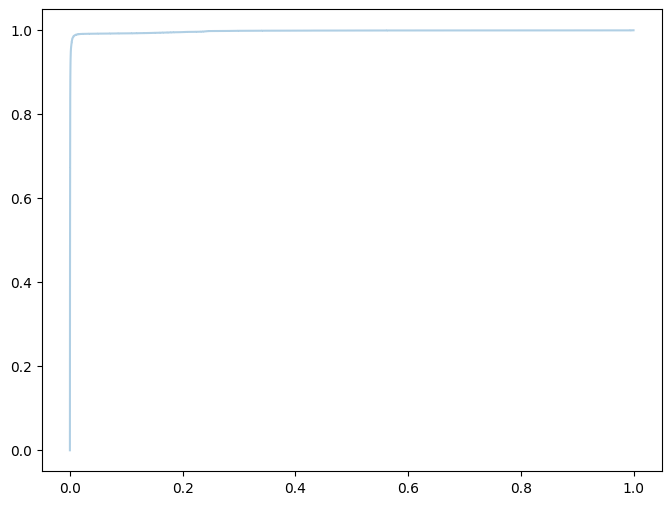

In [10]:
fig, ax, fold_rocs, test_auc = plot_roc_per_fold_and_test(
    best_estimator,
    X_dev, y_dev,
    X_test, y_test,
    cv=cv,
    multi_class="ovr",
    average_auc="weighted",
    title=f"ROC"
)
plt.show()

In [ ]:
import sys, json, hashlib, platform, subprocess, sklearn, scipy, joblib
from sklearn.metrics import classification_report


out_dir = Path("models/2025-12-26_sgd_logreg_v1")
out_dir.mkdir(parents=True, exist_ok=True)

# 1) сохраняем pipeline
joblib.dump(best_estimator, out_dir / "model.joblib", compress=3)

# 2) метрики на test (у вас уже есть y_test, y_pred)
(out_dir / "report_test.txt").write_text(
    classification_report(y_test, y_test_pred),
    encoding="utf-8"
)

meta = {
    "created_at": "2025-12-26T01:19:00Z",
    "python": sys.version,
    "platform": platform.platform(),
    "versions": {
        "sklearn": sklearn.__version__,
        "numpy": np.__version__,
        "scipy": scipy.__version__,
        "pandas": pd.__version__,
        "joblib": joblib.__version__,
    },
    "training": {
        "active_model": cfg["active_model"],
        "best_params": best_params or {},
        "best_score_val": float(best_score) if "best_score" in locals() else None,
        "scoring": "f1_weighted",
        "random_state_split": 42,
        "test_size": 0.15,
    },
    "model": {
        "type": type(best_estimator.named_steps["clf"]).__qualname__,
        "classes": best_estimator.named_steps["clf"].classes_.tolist(),
    },
}

(out_dir / "meta.json").write_text(json.dumps(meta, ensure_ascii=False, indent=2), encoding="utf-8")

879